# 1. Import Library

In [1]:
#!pip uninstall graphviz
#pip install graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Diode/Anaconda3/envs/TF2_GPU/Library/bin/graphviz/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Graph


Bad key "text.kerning_factor" on line 4 in
C:\Users\Diode\Anaconda3\envs\TF2_GPU\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# 2. Write Function

### 2.1 หาคำถามที่แบ่งต้นไม้ได้ดีที่สุด

In [3]:
def DT_find_best_question(X, Y, Feature_Name, All_Class):
    max_Gain = -np.inf
    isComplete = False
    Gini_Parent = DT_compute_Gini(Y, All_Class)
    Question_Dict = DT_create_Question(X, Feature_Name)
    #print(Question_Dict)
    for d, fn in enumerate(Feature_Name):
        N = X.shape[0]
        if fn in Question_Dict:
            unique_value = Question_Dict[fn]['unique_value']
            check_type = Question_Dict[fn]['type_of_feature']
            for i, uv in enumerate(unique_value):                
                filter_true, filter_false = DT_find_filter(X, check_type, d, uv)
                X_True = X[filter_true]; Y_True = Y[filter_true];
                X_False = X[filter_false]; Y_False = Y[filter_false];
                weight_true, weight_false = DT_compute_weight_true_false(filter_true, filter_false, N)
                Gini_True, Gini_False = DT_compute_Gini_True_False(Y_True, Y_False, All_Class)
                Gini_Children = DT_compute_Gini_Children(weight_true, Gini_True, weight_false, Gini_False)
                Gain = DT_compute_Gain(Gini_Parent, Gini_Children)
                if Gain >= max_Gain:
                    max_Gain = Gain
                    best = {}
                    best['fn'] = fn
                    best['findex'] = d
                    best['uv'] = uv
                    best['X_True'] = X_True
                    best['Y_True'] = Y_True
                    best['X_False'] = X_False
                    best['Y_False'] = Y_False
                if max_Gain == Gini_Parent:
                    isComplete = True
                    return best, isComplete
    return best, isComplete

In [4]:
def DT_create_Question(X, Feature_Name):
    Question_Dict = {}
    for d, fn in enumerate(Feature_Name):
        unique_value = np.unique(X[:, d])
        check_type = type(unique_value[0])
        if check_type == str:
            if len(unique_value) >= 2:
                if len(unique_value) == 2:
                    unique_value = unique_value[:1]
                q = {}
                q['type_of_feature'] = 'discrete'
                q['unique_value'] = unique_value
                Question_Dict[fn] = q
        if (check_type == int) or (check_type == float):
            unique_value = unique_value[1:-1]
            if len(unique_value) != 0:            
                q = {}
                q['type_of_feature'] = 'continuous'
                q['unique_value'] = unique_value
                Question_Dict[fn] = q
    return Question_Dict

In [5]:
def DT_compute_Gini(Y, All_Class):
    n_class = len(All_Class)
    N = Y.shape[0]
    if N == 0:
        Gini = 0
    elif N != 0 :
        p = np.zeros([1, n_class])
        for c, _class in enumerate(All_Class):
            p[0, c] = (Y == _class).sum()/N
        Gini = 1 - (p**2).sum()
    return Gini

In [6]:
def DT_find_filter(X, check_type, d, uv):
    if check_type == 'discrete':
        filter_true = np.argwhere(X[:, d] == uv).ravel()
        filter_false = np.argwhere(X[:, d] != uv).ravel()
    elif check_type == 'continuous':
        filter_true = np.argwhere(X[:, d] >= uv).ravel()
        filter_false = np.argwhere(X[:, d] < uv).ravel()
    return filter_true, filter_false

In [7]:
def DT_compute_weight_true_false(filter_true, filter_false, N):
    count_true = len(filter_true)
    count_false = N - count_true
    weight_true = count_true/N
    weight_false = count_false/N
    return weight_true, weight_false

In [8]:
def DT_compute_Gini_True_False(Y_True, Y_False, All_Class):
    Gini_True = DT_compute_Gini(Y_True, All_Class)
    Gini_False = DT_compute_Gini(Y_False, All_Class)
    return Gini_True, Gini_False

In [9]:
def DT_compute_Gini_Children(weight_true, Gini_True, weight_false, Gini_False):
    Gini_Children = weight_true*Gini_True + weight_false*Gini_False
    return Gini_Children

In [10]:
def DT_compute_Gain(Gini_Parent, Gini_Children):
    Gain = Gini_Parent - Gini_Children
    return Gain

### 2.2 ปลูกต้นไม้

In [11]:
def DT_grow_tree(best, Y_True, Y_False, All_Class):
    fn = best['fn']
    findex = best['findex']
    uv = best['uv']
    if type(uv) == str:
        type_of_feature = 'discrete'
    elif (type(uv) == float) or (type(uv) == int):
        type_of_feature = 'continuous'
    
    Question = {} 
    Question['fn'] = fn
    Question['findex'] = findex; Question['uv'] = uv
    Question['type_of_feature'] = type_of_feature
    
    Leaf_Node_True, Vote_True, Max_Vote_True, Max_Class_True = DT_Leaf(Y_True, All_Class)
    True_Branch = {}
    True_Branch['Leaf_Node'] = Leaf_Node_True
    True_Branch['Vote'] = Vote_True
    True_Branch['Predict'] = Max_Class_True
    True_Branch['Percent'] = Max_Vote_True
    
    Leaf_Node_False, Vote_False, Max_Vote_False, Max_Class_False = DT_Leaf(Y_False, All_Class)
    False_Branch = {} 
    False_Branch['Leaf_Node'] = Leaf_Node_False
    False_Branch['Vote'] = Vote_False
    False_Branch['Predict'] = Max_Class_False
    False_Branch['Percent'] = Max_Vote_False
    
    Decision_Node = {}
    Decision_Node['Question'] = Question
    Decision_Node['True_Branch'] = True_Branch
    Decision_Node['False_Branch'] = False_Branch
    
    return Decision_Node, Max_Vote_True, Max_Vote_False

In [12]:
def DT_Leaf(Y, All_Class):
    N = Y.shape[0]
    leaf_node = {}
    vote = {}
    max_vote = -np.inf
    for c, _class in enumerate(All_Class):
        length = (Y == _class).sum()
        percent_vote = 100*length/N
        if max_vote < percent_vote:
            max_vote = percent_vote
            max_class = _class
        leaf_node[_class] = length
        vote[_class] = percent_vote
    return leaf_node, vote, max_vote, max_class

### 2.3 เรียนรู้

In [13]:
def DT_fit(X_Train, Y_Train, Feature_Name, All_Class, max_depth=np.inf, depth=1, max_majority=np.inf, min_leaf=-np.inf):
    best, isComplete = DT_find_best_question(X_Train, Y_Train, Feature_Name, All_Class)
    Y_True = best['Y_True']
    Y_False = best['Y_False']
    Decision_Node, Max_Vote_True, Max_Vote_False = DT_grow_tree(best, Y_True, Y_False, All_Class)
    
    if max_depth == depth:
        return Decision_Node
    if isComplete == True:
        return Decision_Node
    
    if Max_Vote_True < max_majority:
        if len(Y_True) > min_leaf:
            X_True = best['X_True']
            Decision_Node['True_Branch']['Decision_Node']  = DT_fit(X_True, Y_True, Feature_Name, All_Class, max_depth=max_depth, depth=depth+1, max_majority=max_majority, min_leaf=min_leaf)
    if Max_Vote_False < max_majority:
        if len(Y_False) > min_leaf:
            X_False = best['X_False']
            Decision_Node['False_Branch']['Decision_Node'] = DT_fit(X_False ,Y_False, Feature_Name, All_Class, max_depth=max_depth, depth=depth+1, max_majority=max_majority, min_leaf=min_leaf)
    print('Decision_Node ' + str(Decision_Node))
    return Decision_Node

### 2.4 พยากรณ์

In [14]:
def DT_recursive_predict(x_test, tree):
    fn = tree['Question']['fn']
    findex = tree['Question']['findex']
    value = tree['Question']['uv']
    type_of_feature = tree['Question']['type_of_feature']

    if type_of_feature == 'discrete':
        if x_test[findex] == value:
            if 'Decision_Node' not in tree['True_Branch']:
                predict = tree['True_Branch']['Predict']
                percent = tree['True_Branch']['Percent']
                yhat = np.array([predict, percent])
                return yhat
            elif 'Decision_Node' in tree['True_Branch']:
                tree = tree['True_Branch']['Decision_Node']
                yhat = DT_recursive_predict(x_test, tree)
                return yhat
        elif x_test[findex] != value:
            if 'Decision_Node' not in tree['False_Branch']:
                predict = tree['False_Branch']['Predict']
                percent = tree['False_Branch']['Percent']
                yhat = np.array([predict, percent])
                return yhat
            elif 'Decision_Node' in tree['False_Branch']:
                tree = tree['False_Branch']['Decision_Node']
                yhat = DT_recursive_predict(x_test, tree)
                return yhat
                
    if type_of_feature == 'continuous':
        if x_test[findex] >= value:
            if 'Decision_Node' not in tree['True_Branch']:
                predict = tree['True_Branch']['Predict']
                percent = tree['True_Branch']['Percent']
                yhat = np.array([predict, percent])
                return yhat
            elif 'Decision_Node' in tree['True_Branch']:
                tree = tree['True_Branch']['Decision_Node']
                yhat = DT_recursive_predict(x_test, tree)
                return yhat
        elif x_test[findex] < value:
            if 'Decision_Node' not in tree['False_Branch']:
                predict = tree['False_Branch']['Predict']
                percent = tree['False_Branch']['Percent']
                yhat = np.array([predict, percent])
                return yhat
            elif 'Decision_Node' in tree['False_Branch']:
                tree = tree['False_Branch']['Decision_Node']
                yhat = DT_recursive_predict(x_test, tree)
                return yhat

In [15]:
def DT_predict(X_Test, tree):
    Yhat = []
    for x_test in X_Test:
        yhat = DT_recursive_predict(x_test, tree)
        Yhat.append(yhat)
    return np.array(Yhat)

In [16]:
def find_error_classification(Y, Yhat):
    N = Y.shape[0]
    error = (100/N)*(Y != Yhat).sum()
    return error

### 2.5 วาดต้นไม้

In [17]:
def DT_print_tree(node, prev_id, spacing=""):
    global curr_id  
    curr_id += 1
    
    if 'Question' not in node:
        node_predictions = "{} : {}".format(node['Predict'], round(node['Percent'], 2))
        g.node(str(prev_id), label=str(node_predictions))
        return
    
    node_question = "{} {} {}".format(node['Question']['fn'], '=' if isinstance(node['Question']['uv'], str) else '>=', node['Question']['uv'] if isinstance(node['Question']['uv'], str) else round(node['Question']['uv'], 6))
    g.node(str(prev_id), label=str(node_question))

    true_node = node['True_Branch']['Decision_Node'] if 'Decision_Node' in node['True_Branch'] else node['True_Branch']
    V.append((prev_id, curr_id))
    DT_print_tree(true_node, curr_id, spacing + "  ")
    
    false_node = node['False_Branch']['Decision_Node'] if 'Decision_Node' in node['False_Branch'] else node['False_Branch']
    V.append((prev_id, curr_id))
    DT_print_tree(false_node, curr_id, spacing + "  ")

# 3. Read Data & Prepare Data

In [18]:
Data = pd.read_excel('EURUSD.xlsx', usecols = 'AN:AX', skiprows = range(1, 7))

In [19]:
Data

,Delta 5,DD 5,Delta 4,DD 4,Delta 3,DD 3,Delta 2,DD 2,Delta 1,DD 1,Trend
0,0.01610,0.01120,-0.00650,-0.02260,0.01391,0.02041,-0.00055,-0.01446,0.00539,0.00594,-1
1,-0.00650,-0.02260,0.01391,0.02041,-0.00055,-0.01446,0.00539,0.00594,-0.00237,-0.00776,-1
2,0.01391,0.02041,-0.00055,-0.01446,0.00539,0.00594,-0.00237,-0.00776,-0.00180,0.00057,-1
3,-0.00055,-0.01446,0.00539,0.00594,-0.00237,-0.00776,-0.00180,0.00057,-0.01066,-0.00886,1
4,0.00539,0.00594,-0.00237,-0.00776,-0.00180,0.00057,-0.01066,-0.00886,0.01930,0.02996,1
...,...,...,...,...,...,...,...,...,...,...,...
4121,0.00228,0.00232,0.00318,0.00090,-0.00194,-0.00512,0.00013,0.00207,-0.00073,-0.00086,-1
4122,0.00318,0.00090,-0.00194,-0.00512,0.00013,0.00207,-0.00073,-0.00086,-0.00417,-0.00344,-1
4123,-0.00194,-0.00512,0.00013,0.00207,-0.00073,-0.00086,-0.00417,-0.00344,-0.00321,0.00096,-1
4124,0.00013,0.00207,-0.00073,-0.00086,-0.00417,-0.00344,-0.00321,0.00096,-0.00011,0.00310,-1


In [20]:
DataMatrix = Data.values

In [21]:
DataMatrix = np.array(DataMatrix, dtype='object')

In [22]:
DataMatrix.shape

(4126, 11)

In [23]:
D = DataMatrix.shape[1] - 1

In [24]:
X = DataMatrix[:, :D]
Y = DataMatrix[:, D:]

In [25]:
start_train = -900
end_train = -150
# end_test = -150

In [26]:
X_Train = X[start_train:end_train, :]
Y_Train = Y[start_train:end_train, :]

X_Test = X[end_train:, :]
Y_Test = Y[end_train:, :]

# X_Test = X[end_train:end_test, :]
# Y_Test = Y[end_train:end_test, :]

In [37]:
X_Train

array([[0.0021299999999999653, 0.006939999999999946,
        0.014469999999999983, ..., 0.0045000000000001705,
        -0.007009999999999961, 0.0021599999999999397],
       [0.014469999999999983, 0.012340000000000018,
        -0.013670000000000071, ..., 0.0021599999999999397,
        0.006680000000000019, 0.01368999999999998],
       [-0.013670000000000071, -0.028140000000000054,
        -0.0091699999999999, ..., 0.01368999999999998,
        0.004350000000000076, -0.0023299999999999432],
       ...,
       [-0.0014200000000001989, -0.006330000000000169,
        -0.0031200000000000117, ..., 0.005849999999999911,
        -0.0013000000000000789, 0.00039999999999995595],
       [-0.0031200000000000117, -0.0016999999999998128,
        -0.007549999999999946, ..., 0.00039999999999995595,
        0.0044800000000000395, 0.005780000000000118],
       [-0.007549999999999946, -0.004429999999999934,
        -0.0017000000000000348, ..., 0.005780000000000118,
        0.0011700000000001154, -0.0033099

In [38]:
Y_Train

array([[1.0],
       [1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [-1.0],
       [1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [-1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [1.0],
       [1.0],
       [-1.0],
       [-1.0],
       [-1.0],
       [1.0],
       [1.0],
       [1.0],
       [-1.0],
       [1.0],
       [1.0],
       [1.0],

# 4. Create Model

In [27]:
Feature_Name = np.array(Data.columns[:-1])
All_Class, Count_All_Class = np.unique(Y_Train[:, :], return_counts = True)

In [39]:
All_Class

array([-1.0, 1.0], dtype=object)

In [40]:
Count_All_Class

array([370, 380], dtype=int64)

In [28]:
Feature_Name

array(['Delta 5', 'DD 5', 'Delta 4', 'DD 4', 'Delta 3', 'DD 3', 'Delta 2',
       'DD 2', 'Delta 1', 'DD 1'], dtype=object)

In [29]:
tree = DT_fit(X_Train, Y_Train, Feature_Name, All_Class, max_depth = 5, max_majority = 65, min_leaf = 20)

Decision_Node {'Question': {'fn': 'Delta 3', 'findex': 4, 'uv': -0.0043400000000000105, 'type_of_feature': 'continuous'}, 'True_Branch': {'Leaf_Node': {-1.0: 43, 1.0: 49}, 'Vote': {-1.0: 46.73913043478261, 1.0: 53.26086956521739}, 'Predict': 1.0, 'Percent': 53.26086956521739, 'Decision_Node': {'Question': {'fn': 'Delta 1', 'findex': 8, 'uv': 0.005769999999999831, 'type_of_feature': 'continuous'}, 'True_Branch': {'Leaf_Node': {-1.0: 20, 1.0: 12}, 'Vote': {-1.0: 62.5, 1.0: 37.5}, 'Predict': -1.0, 'Percent': 62.5}, 'False_Branch': {'Leaf_Node': {-1.0: 23, 1.0: 37}, 'Vote': {-1.0: 38.333333333333336, 1.0: 61.666666666666664}, 'Predict': 1.0, 'Percent': 61.666666666666664}}}, 'False_Branch': {'Leaf_Node': {-1.0: 16, 1.0: 4}, 'Vote': {-1.0: 80.0, 1.0: 20.0}, 'Predict': -1.0, 'Percent': 80.0}}
Decision_Node {'Question': {'fn': 'Delta 4', 'findex': 2, 'uv': -0.00026999999999999247, 'type_of_feature': 'continuous'}, 'True_Branch': {'Leaf_Node': {-1.0: 78, 1.0: 36}, 'Vote': {-1.0: 68.42105263157

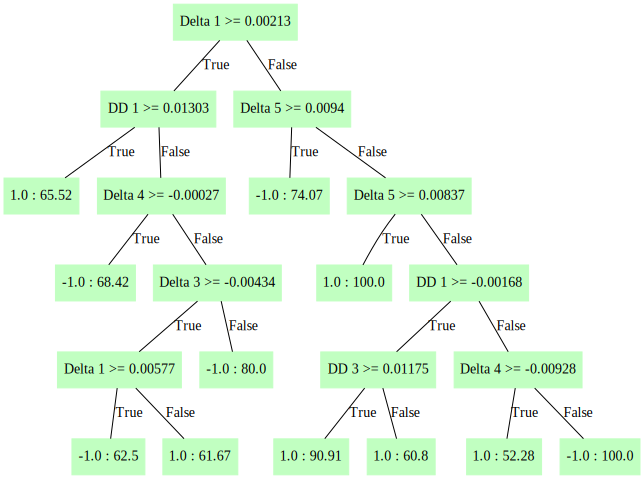

In [30]:
g = Graph('G')
g.attr('node', shape='box', style='filled', color='darkseagreen1')
curr_id = 1   
V = []
DT_print_tree(tree, curr_id)

for v in V:
    g.edge(str(v[0]), str(v[1]), 'True' if v[1] - v[0] == 1 else 'False')
g

# 5. Making Prediction

In [31]:
X_Test

array([[-0.0017000000000000348, 0.005849999999999911,
        -0.0013000000000000789, ..., -0.003309999999999924,
        -0.008299999999999974, -0.00947000000000009],
       [-0.0013000000000000789, 0.00039999999999995595,
        0.0044800000000000395, ..., -0.00947000000000009,
        -0.011759999999999993, -0.0034600000000000186],
       [0.0044800000000000395, 0.005780000000000118,
        0.0011700000000001154, ..., -0.0034600000000000186,
        0.0038599999999999746, 0.015619999999999967],
       ...,
       [-0.0019400000000000528, -0.005120000000000013,
        0.00012999999999996348, ..., -0.0034400000000001096,
        -0.003209999999999935, 0.0009600000000000719],
       [0.00012999999999996348, 0.0020700000000000163,
        -0.0007299999999998974, ..., 0.0009600000000000719,
        -0.0001100000000000545, 0.0030999999999998806],
       [-0.0007299999999998974, -0.0008599999999998609,
        -0.004170000000000007, ..., 0.0030999999999998806,
        -0.011300000000000

In [32]:
X_Test[0]

array([-0.0017000000000000348, 0.005849999999999911,
       -0.0013000000000000789, 0.00039999999999995595,
       0.0044800000000000395, 0.005780000000000118, 0.0011700000000001154,
       -0.003309999999999924, -0.008299999999999974, -0.00947000000000009],
      dtype=object)

In [33]:
Yhat_Test = DT_predict(X_Test, tree)

In [34]:
Yhat_Test

array([[  1.        ,  52.28215768],
       [  1.        ,  52.28215768],
       [  1.        ,  65.51724138],
       [  1.        ,  52.28215768],
       [  1.        ,  90.90909091],
       [ -1.        ,  68.42105263],
       [ -1.        ,  62.5       ],
       [ -1.        ,  68.42105263],
       [ -1.        ,  68.42105263],
       [ -1.        ,  68.42105263],
       [  1.        ,  52.28215768],
       [  1.        ,  65.51724138],
       [ -1.        ,  68.42105263],
       [  1.        ,  52.28215768],
       [  1.        ,  60.8040201 ],
       [  1.        ,  52.28215768],
       [  1.        ,  52.28215768],
       [ -1.        ,  68.42105263],
       [  1.        ,  52.28215768],
       [  1.        ,  61.66666667],
       [  1.        ,  52.28215768],
       [  1.        ,  52.28215768],
       [ -1.        ,  68.42105263],
       [  1.        ,  52.28215768],
       [  1.        ,  60.8040201 ],
       [ -1.        ,  68.42105263],
       [  1.        ,  52.28215768],
 

In [35]:
error_Test = find_error_classification(Y_Test, Yhat_Test[:, 0:1])

In [36]:
error_Test

46.0